In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_squared_error,
)

sns.set_theme()

d:\GitHub\itmo_timeseries\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
class DataProcesser:
    def load_data(self, sales_path, prices_path, dates_path):
        self.sales = pd.read_csv(sales_path)
        self.prices = pd.read_csv(prices_path)
        self.dates = pd.read_csv(dates_path)
        print('данные загружены')

    def get_holidays(self):
        dates_data = self.dates.copy()
        dates_data['date'] = pd.to_datetime(dates_data['date'])
        dates_data['event'] = dates_data['event_name_1'].combine_first(
            dates_data['event_name_2']
        )
        holidays = dates_data.dropna(subset=['event'])[['date', 'event']]
        return holidays.rename(columns={'date': 'ds', 'event': 'holiday'})

    def get_processed_data(self, art):
        if not art:
            raise ValueError('укажите артикул (item_id)')

        df = (
            self.dates.merge(self.sales, on='date_id')
            .merge(self.prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
            .sort_values(by='date')
        )

        df['is_weekend'] = df['wday'].apply(lambda x: 1 if x < 3 else 0)
        df = pd.get_dummies(df, columns=['event_type_1'], prefix='type', dtype=int)

        drop_cols = [
            'wm_yr_wk',
            'year',
            'event_name_1',
            'event_name_2',
            'event_type_2',
            'weekday',
        ]
        for col in ['CASHBACK_STORE_1', 'CASHBACK_STORE_3']:
            if col in df.columns:
                drop_cols.append(col)

        df = df.drop(columns=drop_cols, errors='ignore')
        df['date'] = pd.to_datetime(df['date'])
        df = df.rename(columns={'date': 'ds', 'cnt': 'y'})
        df = df[df.item_id == art]
        self.data = df
        return df

    def get_features(self, data):
        return data.drop(columns=['ds', 'y'])

    def get_split_data(self, data, test_size=90):
        train = data.iloc[:-test_size].copy()
        test = data.iloc[-test_size:].copy()

        mean_sell_price = train['sell_price'].mean()
        train['sell_price'] = train['sell_price'].fillna(mean_sell_price)
        test['sell_price'] = test['sell_price'].fillna(mean_sell_price)

        return train, test

In [3]:
class SalesForecaster:
    def __init__(self):
        self.model = None

    def fit(self, data, holidays=None):
        self.data = data
        self.model = Prophet(holidays=holidays) if holidays is not None else Prophet()

        optional_regressors = [
            'CASHBACK_STORE_2',
            'type_Cultural',
            'type_Sporting',
            'type_Religious',
            'type_National',
            'is_weekend',
            'sell_price',
        ]
        for reg in optional_regressors:
            if reg in data.columns:
                self.model.add_regressor(reg)

        self.model.fit(data)
        print('модель обучена')

    def predict_period(self, features, num_days):
        future = self.model.make_future_dataframe(periods=num_days)  # type: ignore
        future = future[-num_days:].reset_index(drop=True)
        features = features.reset_index(drop=True)

        if len(features) != num_days:
            raise ValueError(f'ожидается {num_days} строк, но получено {len(features)}')

        for col in features.columns:
            future[col] = features[col].values

        return self.model.predict(future)  # type: ignore

    def get_metrics_report(self, y_true, y_pred):
        y_true_array = y_true.values.flatten()
        y_pred_array = y_pred.values.flatten()
        y_true_mean = np.mean(y_true_array) * np.ones_like(y_true_array)

        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true_array, y_pred_array)
        mae = mean_absolute_error(y_true, y_pred)
        mae_zero = mean_absolute_error(y_true_mean, y_pred_array)

        return pd.DataFrame(
            [mse, r2, mae, mae_zero],
            index=['mse', 'r2', 'mae', 'mae_zero'],
            columns=['value'],
        )

    def save_model(self, path='prophet_model.pkl'):
        if self.model is None:
            raise ValueError('модель не обучена — невозможно сохранить')

        with open(path, 'wb') as f:
            pickle.dump(self.model, f)

        print(f'модель сохранена в {path}')

    def load_model(self, path='prophet_model.pkl'):
        with open(path, 'rb') as f:
            self.model = pickle.load(f)

        print(f'модель загружена из {path}')

# данные по первому магазину

In [4]:
processer = DataProcesser()
processer.load_data(
    sales_path='../data/shop_sales.csv',
    prices_path='../data/shop_sales_prices.csv',
    dates_path='../data/shop_sales_dates.csv',
)

holidays = processer.get_holidays()
art = 'STORE_1_546'
data = processer.get_processed_data(art=art)
data_train, data_test = processer.get_split_data(data, test_size=90)

data.tail()

данные загружены


,ds,wday,month,date_id,CASHBACK_STORE_2,item_id,store_id,y,sell_price,is_weekend,type_Cultural,type_National,type_Religious,type_Sporting
81667,2016-01-17,2,1,1815,0,STORE_1_546,STORE_1,5,5.98,1,0,0,0,0
81712,2016-01-18,3,1,1816,0,STORE_1_546,STORE_1,3,5.98,0,0,1,0,0
81757,2016-01-19,4,1,1817,0,STORE_1_546,STORE_1,1,5.98,0,0,0,0,0
81802,2016-01-20,5,1,1818,0,STORE_1_546,STORE_1,2,5.98,0,0,0,0,0
81847,2016-01-21,6,1,1819,0,STORE_1_546,STORE_1,2,5.98,0,0,0,0,0


# прогноз

In [5]:
forecaster = SalesForecaster()
forecaster.fit(data_train, holidays=holidays)

23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


In [6]:
features_test = processer.get_features(data_test)
forecast = forecaster.predict_period(features_test, num_days=90)
forecaster.get_metrics_report(data_test[['y']], forecast[['yhat']])

,value
mse,6.629545
r2,-0.619351
mae,2.128255
mae_zero,1.805990


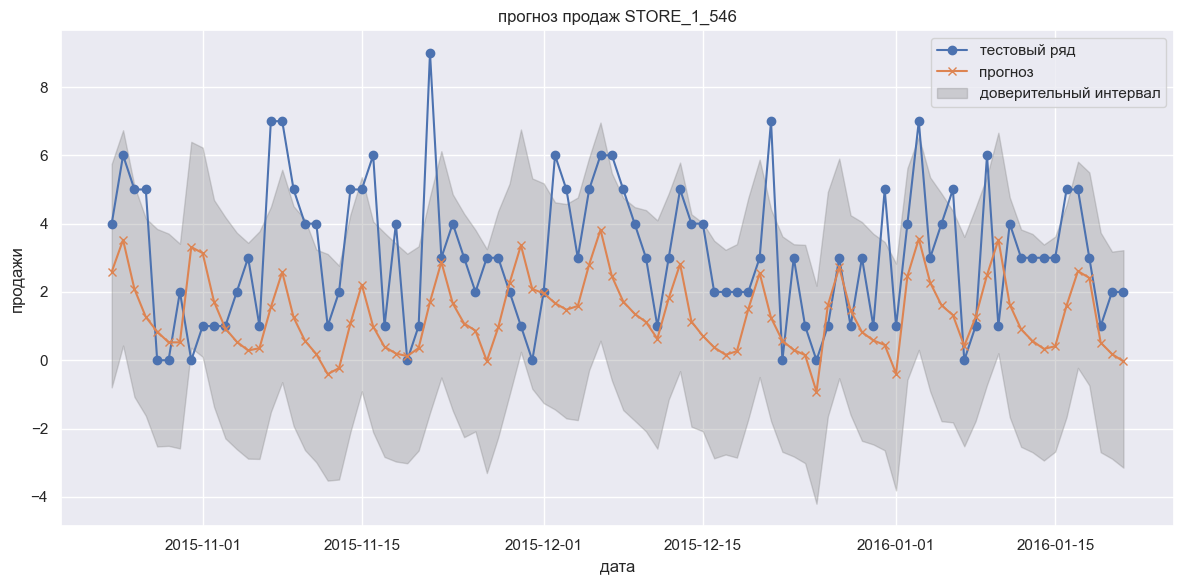

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data_test['ds'], data_test['y'], label='тестовый ряд', marker='o')
plt.plot(data_test['ds'], forecast['yhat'], label='прогноз', marker='x')
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='gray',
    alpha=0.3,
    label='доверительный интервал',
)
plt.title(f'прогноз продаж {art}')
plt.xlabel('дата')
plt.ylabel('продажи')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
forecaster.save_model('prophet_model_store_1_546.pkl')

модель сохранена в prophet_model_store_1_546.pkl


23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:49 - cmdstanpy - INFO - Chain [1] start processing
23:44:49 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:50 - cmdstanpy - INFO - Chain [1] start processing
23:44:50 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:50 - cmdstanpy - INFO - Chain [1] start processing
23:44:50 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:51 - cmdstanpy - INFO - Chain [1] start processing
23:44:51 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:51 - cmdstanpy - INFO - Chain [1] start processing
23:44:52 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:52 - cmdstanpy - INFO - Chain [1] start processing
23:44:52 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:53 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:53 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:55 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:55 - cmdstanpy - INFO - Chain [1] start processing
23:44:55 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:56 - cmdstanpy - INFO - Chain [1] start processing
23:44:56 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


23:44:56 - cmdstanpy - INFO - Chain [1] start processing
23:44:56 - cmdstanpy - INFO - Chain [1] done processing


модель обучена


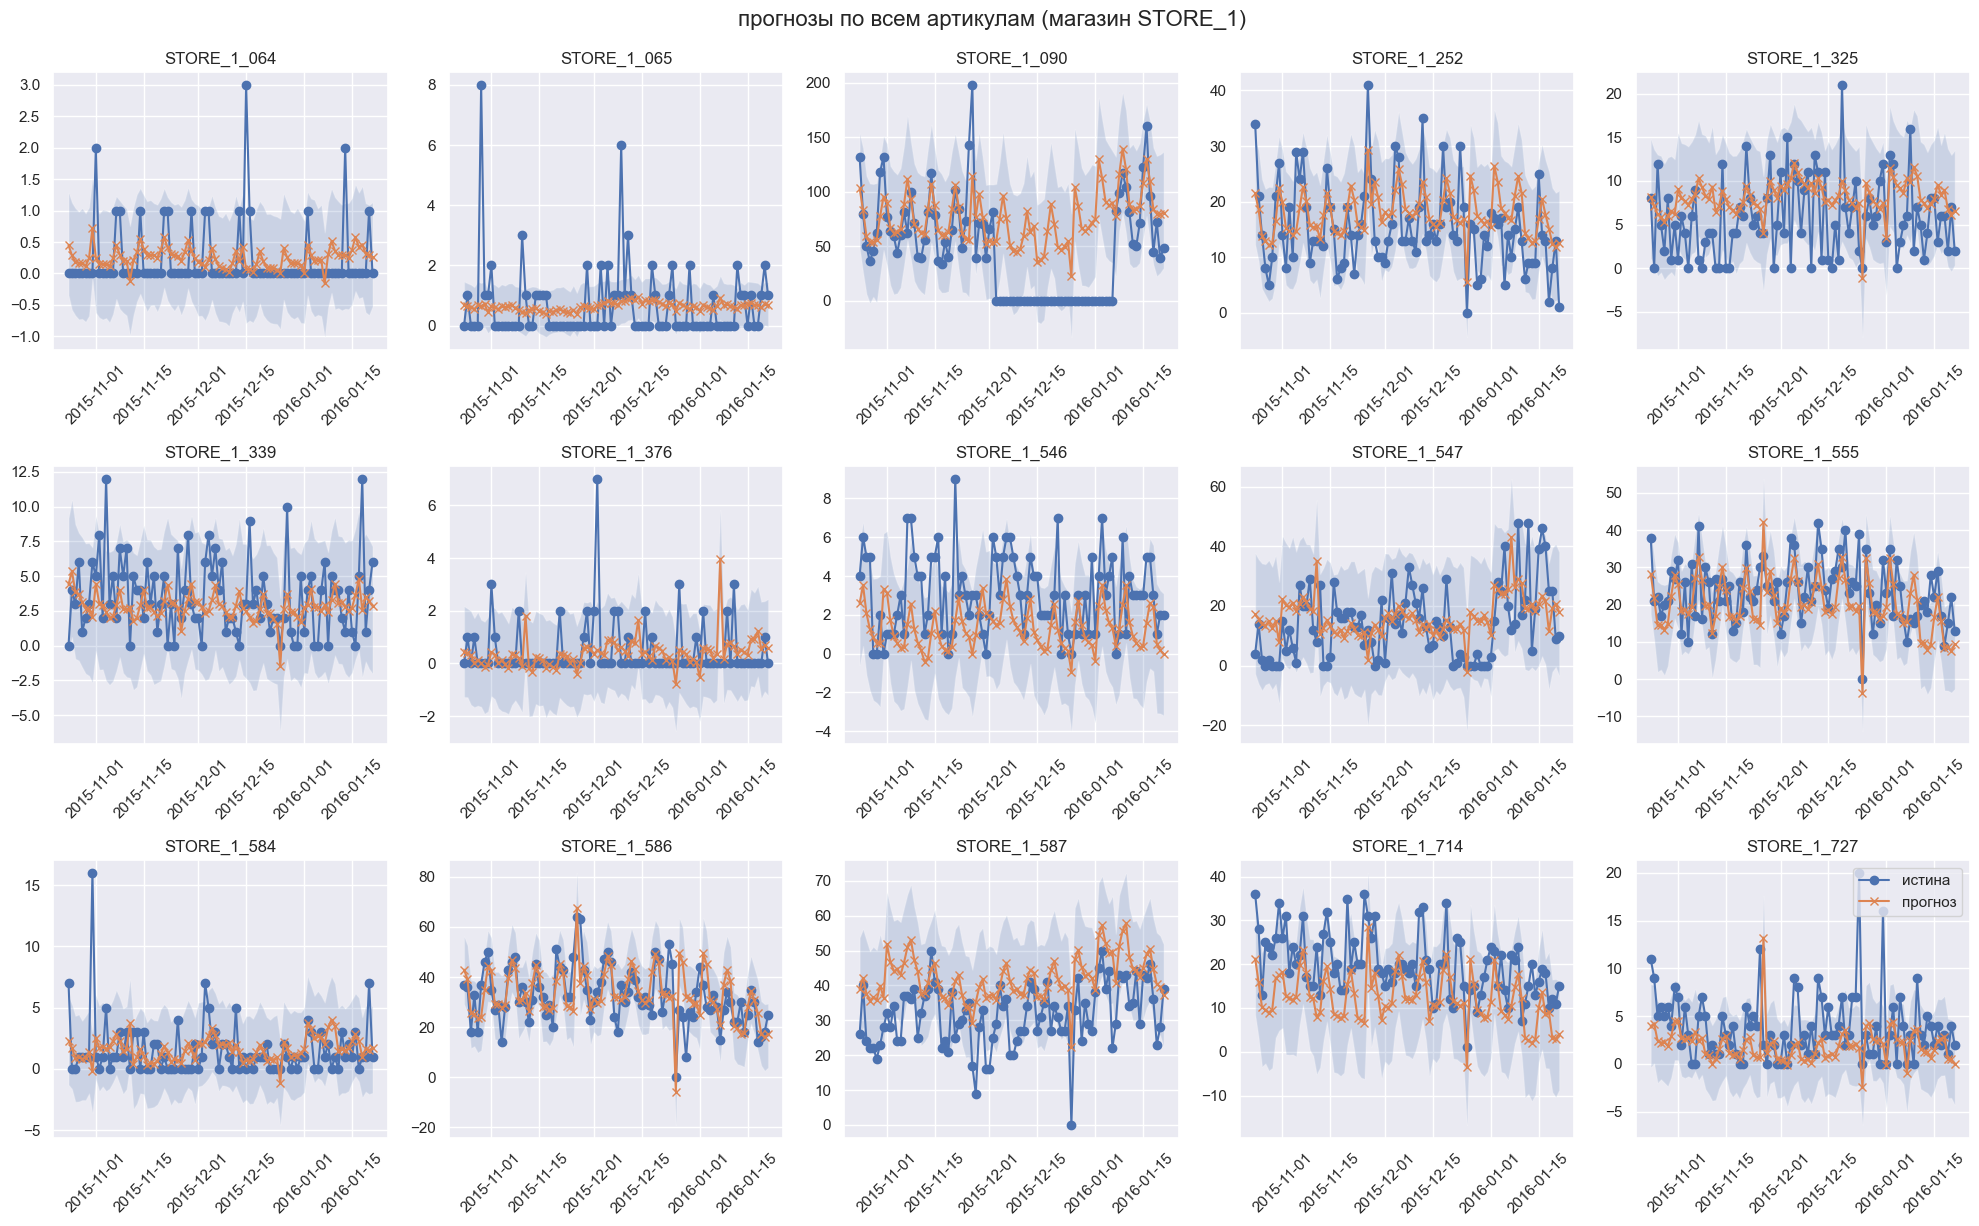

In [9]:
store_items = sorted(
    processer.sales[processer.sales['store_id'] == 'STORE_1']['item_id'].unique()
)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i, item_id in enumerate(store_items):
    try:
        df = processer.get_processed_data(art=item_id)
        train, test = processer.get_split_data(df)
        features = processer.get_features(test)

        model = SalesForecaster()
        model.fit(train, holidays=holidays)
        preds = model.predict_period(features, num_days=90)

        ax = axes[i]
        ax.plot(test['ds'], test['y'], label='истина', marker='o')
        ax.plot(preds['ds'], preds['yhat'], label='прогноз', marker='x')
        ax.fill_between(
            preds['ds'], preds['yhat_lower'], preds['yhat_upper'], alpha=0.2
        )
        ax.set_title(item_id)
        ax.tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[i].set_title(f'{item_id}\nошибка')
        print(f'{item_id}: ошибка прогноза — {e}')

plt.tight_layout()
plt.suptitle('прогнозы по всем артикулам (магазин STORE_1)', fontsize=16, y=1.02)
plt.legend(loc='upper right')
plt.show()

### 1. Какие методы предобработки данных использовали?

- объединение трех таблиц по ключам: `date_id`, `item_id`, `store_id`
- преобразование даты в формат `datetime`
- создание бинарного признака `is_weekend` (сб-вс)
- one-hot-кодирование типа событий (`event_type_1`)
- очистка неиспользуемых колонок
- заполнение пропусков в `sell_price` средним значением по обучающей выборке

### 2. Какие модели пробовали? Почему пробовали именно их?

- использована модель `Prophet` от Facebook, так как:
  - нативно учитывает праздники (регрессоры) и доп. признаки
  - выдает хороший прогноз

### 3. Как проверяете качество модели? На каких данных?
Какие метрики используюте? Чем обусловлен выбор именно этих метрик?

- тестовая выборка: последние 90 дней
- метрики:
  - `MAE` — средняя абсолютная ошибка
  - `MAE_zero` — сравнение с наивным прогнозом (среднее значение)
  - `MSE` и `R^2`

### 4. Какое итоговое качество модели на тестовом датасете?

- ниже приведены метрики, полученные на тестовой выборке
- визуальное сравнение фактических и предсказанных продаж также доступно ниже
